In [ ]:
! python --version

Python 3.7.12


In [ ]:
from IPython.core.debugger import set_trace
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

# import official.nlp.bert.bert_models
# import official.nlp.bert.configs
# import official.nlp.bert.run_classifier
# import official.nlp.bert.tokenization as tokenization

# from official.modeling import tf_utils
# from official import nlp
# from official.nlp import bert

from sklearn.preprocessing import LabelEncoder


from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score


import time

plt.style.use(style="seaborn")
%matplotlib inline

In [ ]:
string.punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
     |████████████████████████████████| 352 kB 54.7 MB/s 
     |████████████████████████████████| 4.4 MB 29.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
     |████████████████████████████████| 636 kB 48.7 MB/s 
     |████████████████████████████████| 211 kB 45.9 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=8887f08839c667be017a67c5d9c3f36431af639e1c5321a5502d410389a7b423
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=63540c82606bf811f

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
dataset1 = pd.read_csv("/content/twitter15-dataset.csv", delimiter=',')
dataset2 = pd.read_csv("/content/twitter16-dataset.csv", delimiter=',')
rumor_df = pd.concat([dataset1, dataset2])
pd.set_option('display.max_colwidth' , 300)
print(rumor_df.shape)
df = rumor_df

(1733, 2)


In [ ]:
df.head()

,post,label
0,america is a nation of second chances —@potus on new reforms to solitary confinement: URL URL,non-rumor
1,"brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL",non-rumor
2,rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL,rumor
3,"former 3 doors down guitarist matt roberts has died at age 38, according to his father. URL URL",non-rumor
4,just in: missing afghan soldiers found trying to enter canada near niagara falls URL URL,rumor


In [ ]:
df = df.iloc[1: , :]
df.label.unique()

array(['non-rumor', 'rumor'], dtype=object)

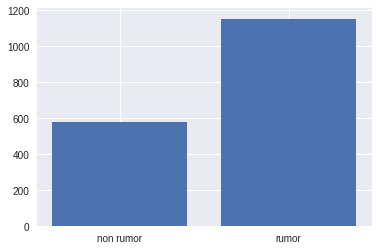

In [ ]:
classes = df.label.unique()
counts = []

for i in classes:
  count = len(df[df.label==i])
  counts.append(count)

plt.bar(['non rumor', 'rumor'], counts)
plt.show()

In [ ]:

import re

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

# import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)    

df["post"] = df.post.map(lambda x: remove_URL(x))
df["post"] = df.post.map(lambda x: remove_html(x))
df["post"] = df.post.map(lambda x: remove_emoji(x))
df["post"] = df.post.map(lambda x: remove_punct(x))



# df['cleanpost'] = df['post'].apply(lambda x: clean_text(x))
# fakeOrreal = {'fake' : 0 , 'real' : 1 }
# df['label'] = df['label'].map(fakeOrreal)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,post,label
1,brandon marshall visits and offers advice support to brother of fallen hero zaevion dobson URL URL,non-rumor
2,rip elly may clampett so sad to learn beverlyhillbillies star donna douglas has passed away URL,rumor
3,former 3 doors down guitarist matt roberts has died at age 38 according to his father URL URL,non-rumor
4,just in missing afghan soldiers found trying to enter canada near niagara falls URL URL,rumor
5,riphulkhogan my heart is ripping like your shirt wwell miss you,rumor


In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


df["post"] = df["post"].map(remove_stopwords)    
df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,post,label
1,brandon marshall visits offers advice support brother fallen hero zaevion dobson url url,non-rumor
2,rip elly may clampett sad learn beverlyhillbillies star donna douglas passed away url,rumor
3,former 3 doors guitarist matt roberts died age 38 according father url url,non-rumor
4,missing afghan soldiers found trying enter canada near niagara falls url url,rumor
5,riphulkhogan heart ripping like shirt wwell miss,rumor


In [ ]:
data = df.post.values
label = df.label.values
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.20, random_state=32)

Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(label)
encoded_Y_test = encoder.transform(label_test)
encoded_Y_train = encoder.transform(label_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
# encoder_fname = 'twitter_classes.npy'
# my_wd = '/content/'
# np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

To load it when you'll use this in production just use the below cell (uncommented ofcourse)

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization 

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained BERT model itself.
First we get the BERT model. I'll use the multilingual one as it will be best for most of your cases. To check all NLP models provided by TF HUB go here.

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

You can see that in above cell we have loaded some variables using the bert_layer we have downloaded.

vocab_file reads the vocab file associated to the downloaded model.
do_lower_case reads binary variable which if True means tokenizer will reformat all text to lower case rendering model to be NOT case sensitive. Should be False by default. You can check in a cell below.
tokenizer builds tokenizer using variables 1 and 2.

In [ ]:
do_lower_case

False

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

 by this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

posts = tf.ragged.constant([
    encode_names(n) for n in data_train])

In [ ]:
print('Tokenized posts shape', posts.shape.as_list())

Tokenized posts shape [1385, None]


This is to what our posts have converted to. The ids there are essentially the same as in the simple NN example we did last time, just this time we use a predefined vocabulary.

In [ ]:
posts[0]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([88234, 36064, 10350, 70156,   171, 13020, 11183, 12504, 13510,
       10268, 29632, 45989, 10901, 40394, 19299, 13145, 17781, 14064,
       88767,   102], dtype=int32)>

If you want to see how tokenizer does the "tokenizing" check the cells below.

In [ ]:
data_train[0]

'cnnorc poll clinton best 1st dem debate sanders significantly increased support past month url'

In [ ]:
tokenizedpost = tokenizer.tokenize(data_train[3])
for i in tokenizedpost:
  print(i, tokenizer.convert_tokens_to_ids([i]))

several [11736]
host [19317]
##ages [24115]
free [13961]
##d [10162]
je [10144]
##wis [83648]
##h [10237]
super [25212]
##market [60336]
pari [24289]
##s [10107]
photo [38171]
th [77586]
##omas [57553]
sam [21083]
##son [11599]
af [10452]
##p [10410]
url [88767]


We still need to add classification token.

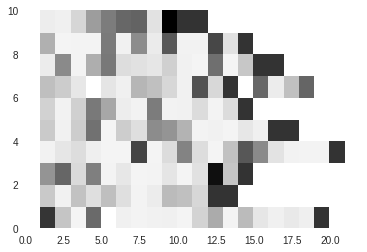

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*posts.shape[0]
input_word_ids = tf.concat([cls, posts], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

What you see above is a graphical representation of our tokenized posts. First token is our classification token. Other colored blocks than background are other tokens. And background, well that's just padding.

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 88234, 36064, 10350, 70156, 171, 13020, 11183, 12504, 13510, 10268, 29632, 45989, 10901, 40394, 19299, 13145, 17781, 14064, 88767, 102], [101, 34481, 12078, 37501, 23103, 38990, 22978, 10944, 16094, 40519, 38465, 27593, 88767, 88767, 102], [101, 53695, 71797, 25973, 61728, 11021, 18745, 10178, 10680, 19630, 10197, 22362, 101003, 36081, 88767, 102], [101, 11736, 19317, 24115, 13961, 10162, 10144, 83648, 10237, 25212, 60336, 24289, 10107, 38171, 77586, 57553, 21083, 11599, 10452, 10410, 88767, 102], [101, 34010, 12620, 32221, 67299, 10107, 32083, 23457, 57057, 53934, 43509, 10407, 12473, 10125, 18939, 13520, 88767, 88767, 102], [101, 30156, 11680, 30811, 64321, 47755, 15034, 12014, 62976, 11758, 12630, 24748, 10877, 24748, 88767, 102], [101, 38969, 32719, 19090, 124, 19573, 13172, 42216, 38465, 27593, 12647, 79601, 27160, 88767, 171, 71492, 15434, 38465, 72078, 102], [101, 16004, 57575, 10835, 45174, 64794, 24173, 22153, 19508, 30785, 12682, 10280, 67878, 10107, 3

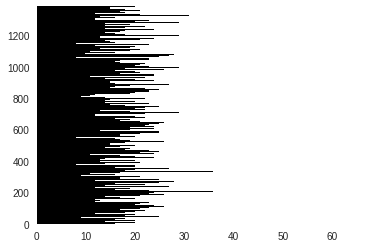

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

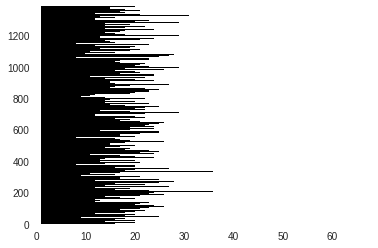

In [ ]:
type_cls = tf.zeros_like(cls)
type_post = tf.ones_like(posts)
input_type_ids = tf.concat([type_cls, type_post], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It's hard to see but we added an empty block in front of each post for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids


<tf.Tensor: shape=(1385, 68), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 68


Most of the time I suggest adding a bit more to the `max_seq_length` esspecially when ussing just a fraction of data. Let's make it `1.5*max_seq_length`.

In [ ]:
max_seq_length = int(240)
print('Max length is:', max_seq_length)

Max length is: 240


Functions themselves.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
data_train = bert_encode(data_train, tokenizer, max_seq_length)
data_test = bert_encode(data_test, tokenizer, max_seq_length)

# Model part 

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [ ]:
num_class

2

Our Model

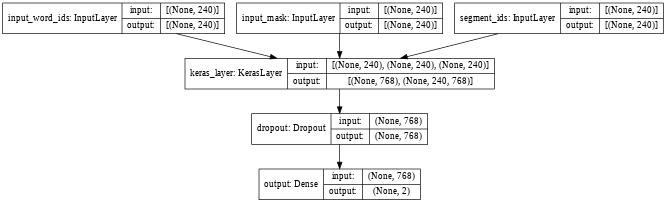

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 4
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile Model

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(data_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(data_test, dummy_y_test),
                    verbose=1)

Epoch 1/4
87/87 [==============================] - 176s 2s/step - loss: 0.6159 - accuracy: 0.6498 - val_loss: 0.5646 - val_accuracy: 0.6974
Epoch 2/4
87/87 [==============================] - 154s 2s/step - loss: 0.4221 - accuracy: 0.8072 - val_loss: 0.5095 - val_accuracy: 0.7896
Epoch 3/4
87/87 [==============================] - 154s 2s/step - loss: 0.2454 - accuracy: 0.9119 - val_loss: 0.5687 - val_accuracy: 0.8156
Epoch 4/4
87/87 [==============================] - 154s 2s/step - loss: 0.1550 - accuracy: 0.9480 - val_loss: 0.5164 - val_accuracy: 0.8329


Evaluation

In [ ]:
loss, accuracy = model.evaluate(data_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

KeyboardInterrupt: ignored

Noice plots are noice

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

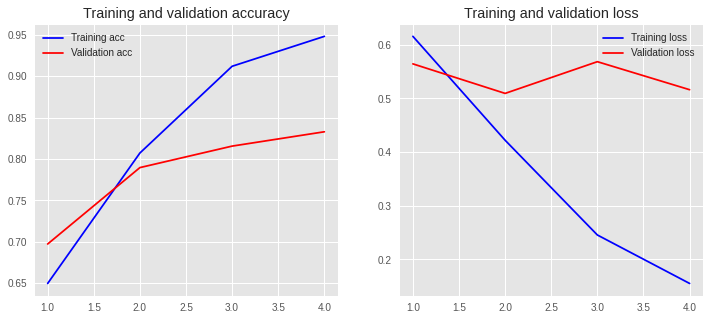

In [ ]:
plot_history(history)

In [ ]:
!pip install lime
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])

In [ ]:
def new_predict(texts):
  _seq = tokenizer.texts_to_sequences(texts)
  _text_data = pad_sequences(
      _seq, maxlen=max_length, padding='post', truncating='post'
  )
  return np.array([[float(1-x), float(x)] for x in model.predict(_text_data)])

In [ ]:

data_test.iloc[-1]

In [ ]:
explanation =explainer.explain_instance(data_test.iloc[-1], new_predict, num_features=max_length, top_labels=1)

In [ ]:
plot_history(history)

So, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\
What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more. \\

## Model saving for later use

Let's save our model for later use. Unfortunatelly we can't use the optimizer we used for model training to save. I get an error and I can't resolve it. So we will recompile our model before saving.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/bertforthesis/'

model.save(os.path.join(my_wd, model_fname))